 Project 4: Web Scraping Job Postings
Business Case Overview
You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal has two main objectives:

Determine the industry factors that are most important in predicting the salary amounts for these data.
Determine the factors that distinguish job categories and titles from each other. For example, can required skills accurately predict job title?
To limit the scope, your principal has suggested that you focus on data-related job postings, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by limiting your search to a single region.



In [1]:
!pip install pyLDAvis

!pip install wordcloud
!pip install requests BeautifulSoup4

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 16.3MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=369fc476fb9855b8ed0112b1d5aebfc26703d173f42fe425e72b7586a4f3922f
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=26d56027074c312a1967ad14e1570c33cc55fc631ed1e51f52d187bbed81a76f
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
import pandas as pd
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

from gensim import corpora

#for scraping
import requests
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import requests
import re

import datetime

import pyLDAvis
import pyLDAvis.sklearn

import pyLDAvis.gensim

pyLDAvis.enable_notebook()

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation

import gensim

from nltk import word_tokenize
from nltk.corpus import stopwords 
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk import WordNetLemmatizer
nltk.download('wordnet')

import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import matplotlib.pyplot as plt
% matplotlib inline



import pyLDAvis.gensim

# Section 1: Job Salary Trends Section 

### Scraping ###

In [0]:
# I am using Beautiful Soup with html.select to scrape my data from Big Data Jobs
# here I am defining the function that I will use to scrape
def simple_get(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None.
    """
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content
            else:
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None

def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)


def log_error(e):
    """
    It is always a good idea to log errors. 
    This function just prints them, but you can
    make it do anything.
    """
    print(e)

In [0]:
base = ('/content/drive/My Drive/Project_4/Job Posting Scraping Project 4.ipynb/')

In [5]:
from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# I am scraping job postings and their accompanying date from Big Data Jobs.com

# declare a list
job_posts = []
base_url = "https://datajobs.com/"


all_job_urls = []
# iteraterate through the 42 pages of job postings
for page in range(1,42):
    
    # make request for that page
    url = base_url + "Big-Data-Jobs~{}".format(page)
    raw_html = simple_get(url)
   
    # turn into a BeautifulSoup object
    html = BeautifulSoup(raw_html, 'lxml')
   


    # find jobs on page
    job_postings =html.select("div.main-container div div div.stealth-header a")
   
    job_urls = [c['href'] for c in job_postings ]
   
    all_job_urls += job_urls
    





    
    

In [0]:
# declare a list

base_url = "https://datajobs.com/"

records = []

# iteraterate through the 42 pages of job postings

for i,end_url in enumerate(all_job_urls):
    job_data = dict()
    job_data['end_url']= end_url
    # make request for that page
    url = base_url + end_url
  
    raw_html = simple_get(url)
   
    # turn into a BeautifulSoup object
    html = BeautifulSoup(raw_html, 'lxml')
    # use html select, and writing the specific paths to find the section I require
    job_title = html.select("div.main-container h1.stealth-header")[0].text
    #getting job title
    job_data['job title'] = job_title

    #getting company name
    company = html.select("div.main-container h2.stealth-header")[0].text
    job_data['company'] = company

    #getting job description
    desc = html.select("#job_description div div.jobpost-table-cell-2.stealth-header")[0].text
    job_data['desc'] = desc

    #getting location, salary and employment type information
    data = html.select('div div div.jobpost-table.stealth-border div div.jobpost-table-cell-2 ')
    job_data['location'] = data[2].text
    job_data['salary'] = data[4].text
    job_data['employment_type'] = 'Full Time'

    #saving it all to me records dictionary   
    records.append(job_data)
    
   

### Data Cleaning ###

In [0]:
#saving it to a dataframe
df = pd.DataFrame(records)

In [9]:
#looking at the head to see what needs to be cleaned
df.head()

end_url  ... employment_type
0  Coppin-State-University-/Assistant-Associate-P...  ...       Full Time
1   Academic-Analytics-L-L-C-/Data-Analyst-Job~16437  ...       Full Time
2      DraftKings/Senior-Software-Engineer-Job~16356  ...       Full Time
3  Voice-Systems-Engineering/Data-Engineer-Job~16340  ...       Full Time
4  Reedy-Creek-Improvement-District/IT-Project-Ma...  ...       Full Time

[5 rows x 7 columns]

In [0]:
# salary currently contains irelevant charachters so I am removing them
# and replacing them with nothing
# except in the cases where they contain salary ranges, there I am creating 
# new columns for high and low salary to contain the low and high ends of the
# listed range

df['salary'] = df['salary'].str.replace('\nEmployment Type:\n\r\n\t\t\t\t\tFull Time\t\t\t\t', '')
df['salary'] = df['salary'].str.replace('\nEmployment Type:\n\r\n\t\t\t\t\tFull TimeSalary range:', '')
df['low_salary'] = df['salary'].str.split(' ', n=1, expand=True)[0]
df['high_salary'] = df['salary'].str.split(' ', n=1, expand=True)[1]
df['low_salary']= df['low_salary'].str.replace('$', '')
df['low_salary']= df['low_salary'].str.replace(',', '')



In [11]:
#I see that only a small number of rows contain any salary values
df['low_salary'].value_counts()

          471
100000      8
50000       7
75000       5
150000      2
90000       1
80000       1
200000      1
160000      1
60000       1
Name: low_salary, dtype: int64

In [12]:
# the high slary column still required further cleaning
df['high_salary'].value_counts()

 $150,000\t\t\t\t    7
 $75,000\t\t\t\t     6
 $100,000\t\t\t\t    6
 $200,000\t\t\t\t    3
and up\t\t\t\t        2
 $90,000\t\t\t\t     1
 $190,000\t\t\t\t    1
 $130,000\t\t\t\t    1
Name: high_salary, dtype: int64

In [0]:
# executing that cleaning as well as neccesary cleaning for the location
# and description columns
df['high_salary']= df['high_salary'].str.replace('$', '')
df['high_salary']= df['high_salary'].str.replace(',', '')
df['high_salary']= df['high_salary'].str.replace('\t\t\t\t' , '')
df['high_salary']= df['high_salary'].str.replace('and up\t\t\t\t', '')
df['high_salary']= df['high_salary'].str.replace('and up', '')
df['high_salary']= df['high_salary'].str.replace('\x96', '')
df['high_salary']= df['high_salary'].str.replace(' ','')
df['low_salary']= df['low_salary'].str.replace(' ','')
df['location']= df['location'].str.replace('\r\n\t\t\t\t\t' , '')
df['location']= df['location'].str.replace('\t\t\t\t\t\n' , '')
df['desc']= df['desc'].str.replace('\n' , '')



In [14]:
df.head()

end_url  ... high_salary
0  Coppin-State-University-/Assistant-Associate-P...  ...        None
1   Academic-Analytics-L-L-C-/Data-Analyst-Job~16437  ...       75000
2      DraftKings/Senior-Software-Engineer-Job~16356  ...        None
3  Voice-Systems-Engineering/Data-Engineer-Job~16340  ...        None
4  Reedy-Creek-Improvement-District/IT-Project-Ma...  ...       75000

[5 rows x 9 columns]

In [15]:
df['high_salary'].value_counts()

150000    7
100000    6
75000     6
200000    3
          2
90000     1
130000    1
190000    1
Name: high_salary, dtype: int64

In [0]:
# converting the values in these columns to be numeric
df['high_salary'] = pd.to_numeric(df['high_salary'])
df['low_salary'] = pd.to_numeric(df['low_salary'])

In [17]:
df.head()

end_url  ... high_salary
0  Coppin-State-University-/Assistant-Associate-P...  ...         NaN
1   Academic-Analytics-L-L-C-/Data-Analyst-Job~16437  ...     75000.0
2      DraftKings/Senior-Software-Engineer-Job~16356  ...         NaN
3  Voice-Systems-Engineering/Data-Engineer-Job~16340  ...         NaN
4  Reedy-Creek-Improvement-District/IT-Project-Ma...  ...     75000.0

[5 rows x 9 columns]

In [0]:
# to deal with the missing values in the salary column
# I will create a salary map to fill them with
# before doing so, I need to rename job titles to a working title column
# then within that column, I will rename job titles to be defined by their
# corresponding category in the salary map
# in the end all jobs titles will be renamed to 25 possible job titles
df['working title'] = df['job title'] 

In [0]:
# I will make all the charachters in working title lowercase for ease of use
df['working title']= df['working title'].str.lower()

In [20]:
# looking at the most often occuring titles
# from the top 20, I get a pretty good sense of what my job category map
# categories should be
df['working title'].value_counts().head(40)

data scientist                                        26
data engineer                                         10
data analyst                                          10
business analyst                                       5
business intelligence analyst                          5
senior data scientist                                  4
senior data engineer                                   4
database administrator                                 4
statistician                                           3
senior software engineer                               3
sr. data scientist                                     3
senior business intelligence consultant                3
software engineer, data infrastructure engineering     3
sr. data engineer                                      2
senior analyst                                         2
sr digital analyst                                     2
senior engineer - data analysis                        2
data warehouse developer       

In [0]:
# my first round of recategorizing is as general as possible
# making use of regex
# but I can not rename everything in this matter because it would write over itself
# and I would end up with all 'senior data scientist' records being renamed 'data scientist' for example

df['working title']= df['working title'].str.replace('sr.', 'senior')

df['working title']= df['working title'].str.replace('.*vice.*president.*','vp data')

df['working title']= df['working title'].str.replace('.*product.*manager.*','product manager')
df['working title']= df['working title'].str.replace('.*manager.*product.*','product manager')

df['working title']= df['working title'].str.replace('.*manager.*data.*analytics.*','senior data analyst')
df['working title']= df['working title'].str.replace('.*manager.*analytics.*','senior data analyst')
df['working title']= df['working title'].str.replace('.*analytics.*manager.*','senior data analyst')
df['working title']= df['working title'].str.replace('.*senior.*analytics.*','senior data analyst')
df['working title']= df['working title'].str.replace('.*head.*of.*analytics.*','senior data analyst')
df['working title']= df['working title'].str.replace('.*senior.*analyst.*','senior data analyst')
df['working title']= df['working title'].str.replace('.*senior.*data.*analyst.*','senior data analyst')
df['working title']= df['working title'].str.replace('.*director.*analytics.*','senior data analyst')


df['working title']= df['working title'].str.replace('growth data analyst.*','data analyst')
df['working title']= df['working title'].str.replace('.*performance.*analyst.*','data analyst')
df['working title']= df['working title'].str.replace('data analyst - tisch.*','data analyst')


df['working title']= df['working title'].str.replace('.*data.*architect.*','data scientist')
df['working title']= df['working title'].str.replace('.*deputy.*data.*scientist.*','data scientist')
df['working title']= df['working title'].str.replace('.*associate.*data.*scientist.*','data scientist')
df['working title']= df['working title'].str.replace('.*research.*data.*scientist.*','data scientist')
df['working title']= df['working title'].str.replace('.*enterprise.*data.*scientist.*','data scientist')
df['working title']= df['working title'].str.replace('.*big.*data.*scientist.*','data scientist')
df['working title']= df['working title'].str.replace('.*machine.*learning.*','data scientist')
df['working title']= df['working title'].str.replace('.*modeler.*','data scientist')
#might need to remove
df['working title']= df['working title'].str.replace('data scientist.*','data scientist')

df['working title']= df['working title'].str.replace('.*v.*p.*','vp data')
df['working title']= df['working title'].str.replace('.*director.*','vp data')
df['working title']= df['working title'].str.replace('.*senior.*data.*engineer.*','senior data engineer')
df['working title']= df['working title'].str.replace('.*senior.*engineer.*','senior data engineer')

df['working title']= df['working title'].str.replace('.*analytics.*data.*engineer.*','data engineer')

df['working title']= df['working title'].str.replace('.*executive.*director.*','vp data')
df['working title']= df['working title'].str.replace('.*president.*','vp data')
df['working title']= df['working title'].str.replace('.*dean.*','vp data')

df['working title']= df['working title'].str.replace('.*senior.*data.*scientist.*','senior data scientist')
df['working title']= df['working title'].str.replace('.*senior.*data.*analyst.*','senior data analyst')
df['working title']= df['working title'].str.replace('.*head.*data.*scientist.*','senior data scientist')
df['working title']= df['working title'].str.replace('.*head.*data.*science.*','senior data scientist')
df['working title']= df['working title'].str.replace('.*head.*data.*architect.*','senior data scientist')
df['working title']= df['working title'].str.replace('.*head.*architect.*','senior data scientist')
df['working title']= df['working title'].str.replace('.*chief.*architect.*','senior data scientist')
df['working title']= df['working title'].str.replace('.*manager.*data.*science.*','senior data scientist')
df['working title']= df['working title'].str.replace('.*data.*science.*manager.*','senior data scientist')
df['working title']= df['working title'].str.replace('.*manager.*data.*scientist.*','senior data scientist')
df['working title']= df['working title'].str.replace('.*manager.*customer.*insight.*','senior data scientist')
df['working title']= df['working title'].str.replace('senior big data solution.*','senior data scientist')

df['working title']= df['working title'].str.replace('.*senior.*dba.*','senior database administrator')
df['working title']= df['working title'].str.replace('.*sr.*database.*engineer.*','senior database administrator')

df['working title']= df['working title'].str.replace('data systems manager','senior database administrator')
df['working title']= df['working title'].str.replace('mysql database administrator','senior database administrator')
df['working title']= df['working title'].str.replace('database administrator administrator','database administrator')
df['working title']= df['working title'].str.replace('.*database.*administrator.*','database administrator')
df['working title']= df['working title'].str.replace('.*database.*engineer.*','database administrator')

df['working title']= df['working title'].str.replace('.*support.*','tech support')

df['working title']= df['working title'].str.replace('.*sr.*dba.*','senior database administrator')
df['working title']= df['working title'].str.replace('.*senior.*database.*','senior database administrator')

df['working title']= df['working title'].str.replace('.*statistician.*','statistician')
df['working title']= df['working title'].str.replace('statistician.*','statistician')


df['working title']= df['working title'].str.replace('.*business.*intelligence.*analyst.*','business intelligence analyst')
df['working title']= df['working title'].str.replace('.*analyst.*business.*intelligence.*','business intelligence analyst')


df['working title']= df['working title'].str.replace('.*business.*intelligence.*manager.*','senior business intelligence analyst')
df['working title']= df['working title'].str.replace('.*senior.*business.*intelligence.*analyst.*','senior business intelligence analyst')

df['working title']= df['working title'].str.replace('.*research.*','research position')
df['working title']= df['working title'].str.replace('.*fellow.*','research position')
df['working title']= df['working title'].str.replace('.*researcher.*','research position')

df['working title']= df['working title'].str.replace('.*senior.*software.*engineer.*','senior software engineer')

df['working title']= df['working title'].str.replace('analytics & reporting engineer','data engineer')

df['working title']= df['working title'].str.replace('.*vsto.*','software engineer')

df['working title']= df['working title'].str.replace('part-time sports content researcher.*','part time')
df['working title']= df['working title'].str.replace('data specialist.*','part time')


df['working title']= df['working title'].str.replace('senior analytics engagement manager.*','senior data analyst')
df['working title']= df['working title'].str.replace('human resources data analytics.*','senior data analyst')
df['working title']= df['working title'].str.replace('assistant.*','assistant')


df['working title']= df['working title'].str.replace('software architect.*','senior software engineer')

df['working title']= df['working title'].str.replace('business intelligence analyst.*','business intelligence analyst')
df['working title']= df['working title'].str.replace('manager, data technology.*','senior data scientist')
df['working title']= df['working title'].str.replace('.*marketing.*analytics.*','data analyst')
df['working title']= df['working title'].str.replace('data science course mentor.*','part time')
df['working title']= df['working title'].str.replace('senior data engineer.*','senior data engineer')
df['working title']= df['working title'].str.replace('revenue planning analyst.*','data analyst')
df['working title']= df['working title'].str.replace('director of business intelligence.*','senior business intelligence analyst')
df['working title']= df['working title'].str.replace('senior web analyst.*','senior data analyst')
df['working title']= df['working title'].str.replace('data analytics project manager.*','senior data analyst')
df['working title']= df['working title'].str.replace('chief data officer.*','senior data scientist')
df['working title']= df['working title'].str.replace('digital analytics.*','data analyst')

In [22]:
# this first round helps a lot, but there is plenty more work to be done
df['working title'].value_counts().head(40)

senior data analyst                                      82
data scientist                                           72
vp data                                                  66
senior data engineer                                     30
database administrator                                   21
senior data scientist                                    17
data analyst                                             12
research position                                        12
data engineer                                            12
business intelligence analyst                            10
statistician                                              8
business analyst                                          5
tech support                                              3
product manager                                           3
senior business intelligence consultant                   3
part time                                                 3
software engineer, data infrastructure e

In [23]:
# I still have a lot of unique job titles, although less than before
df['working title'].unique().sum

<function ndarray.sum>

In [0]:
#round 2
df['working title']= df['working title'].str.replace('search architect','data scientist')
df['working title']= df['working title'].str.replace('solution architect','data scientist')
df['working title']= df['working title'].str.replace('coding specialist','data scientist')
df['working title']= df['working title'].str.replace('computational linguist/speech data scientist','data scientist')
df['working title']= df['working title'].str.replace('r&d data scientist','data scientist')
df['working title']= df['working title'].str.replace('data visualization data scientist','data scientist')
df['working title']= df['working title'].str.replace('senior edi coordinator','data scientist')

df['working title']= df['working title'].str.replace('platform technical lead','software engineer')
df['working title']= df['working title'].str.replace('it project manager','product manager')
df['working title']= df['working title'].str.replace('quantitative engineer, business intelligence','business intelligence analyst')
df['working title']= df['working title'].str.replace('adworks hadoop engineer','software engineer')

df['working title']= df['working title'].str.replace('c.s.r. / data entry','assistant')

df['working title']= df['working title'].str.replace('engineer - data infrastructure','data engineer')
df['working title']= df['working title'].str.replace('operations engineer','data engineer')
df['working title']= df['working title'].str.replace('data engineer, amazon prime - business intelligence','data engineer')
df['working title']= df['working title'].str.replace('release engineer','data engineer')
df['working title']= df['working title'].str.replace('data warehouse engineer','data engineer')
df['working title']= df['working title'].str.replace('sharepoint architect / software engineer','software engineer')

df['working title']= df['working title'].str.replace('enterprise dba manager','database administrator')
df['working title']= df['working title'].str.replace('data warehouse administrator iii','database administrator')

df['working title']= df['working title'].str.replace('systems and operations program officer','product manager')
df['working title']= df['working title'].str.replace('bi program manager','product manager')
df['working title']= df['working title'].str.replace('program manager, enterprise information management','product manager')

In [25]:
#getting there, but not quite
df['working title'].value_counts().head(40)

senior data analyst                                      82
data scientist                                           77
vp data                                                  66
senior data engineer                                     30
database administrator                                   23
senior data scientist                                    17
data engineer                                            17
data analyst                                             12
research position                                        12
business intelligence analyst                            11
statistician                                              8
product manager                                           7
business analyst                                          5
software engineer                                         5
software engineer, data infrastructure engineering        3
tech support                                              3
part time                               

In [26]:
df['working title'].unique()

array(['assistant', 'data analyst', 'senior data engineer',
       'data engineer', 'product manager', 'senior data analyst',
       'research position', 'part time',
       'principal software engineer, big data',
       'staff software engineer, data platform', 'senior data scientist',
       'vp data', 'data scientist', 'database administrator',
       'lead data engineer ', 'senior project manager data integration',
       'data quality engineer', 'data governance analyst',
       'graduate data analytics internship, spring 2019',
       'data analytics: pricing & integration intern, spring 2019',
       'sales analytics & insights intern, spring 2019',
       'decision science internship, spring 2019',
       'advanced analytics analyst', 'senior information architect',
       'pricing analyst (merchandise)', 'staff data engineer',
       'insights analyst', 'senior database administrator',
       'principal architect, data platforms',
       'f&b pricing and revenue management an

In [0]:
#round 3
df['working title']= df['working title'].str.replace('data analyst, asset strategy & optimization','data analyst')         
df['working title']= df['working title'].str.replace('data analyst (merchandise)','data analyst')

df['working title']= df['working title'].str.replace('data analyst and project manager','data analyst')
df['working title']= df['working title'].str.replace('customer relationship management.*','data analyst')
df['working title']= df['working title'].str.replace('analyst, data integrity & analytics','data analyst')
#df['working title']= df['working title'].str.replace('data analyst','data analyst')
df['working title']= df['working title'].str.replace('data analyst.*','data analyst')
df['working title']= df['working title'].str.replace('product analyst','data analyst')


df['working title']= df['working title'].str.replace('software engineer – nosql/real time analytics','software engineer')
df['working title']= df['working title'].str.replace('software engineer - hadoop','software engineer')
df['working title']= df['working title'].str.replace('software engineer - analytics infrastructure','software engineer')
df['working title']= df['working title'].str.replace('software engineer iii - backend voice engineer','software engineer')
df['working title']= df['working title'].str.replace('software engineer, natural language processing','software engineer')
df['working title']= df['working title'].str.replace('software engineer iii, consumer data platforms','software engineer')
df['working title']= df['working title'].str.replace('software engineer / big data','software engineer')
df['working title']= df['working title'].str.replace('senior data analyst (sas)','software engineer')
df['working title']= df['working title'].str.replace('software engineer - analytics','software engineer')
df['working title']= df['working title'].str.replace('software engineer - data-mining','software engineer')
df['working title']= df['working title'].str.replace('software engineer iii, data platforms - voice technology','software engineer')

df['working title']= df['working title'].str.replace('senior data analyst (data science & analysis)','senior data analyst')
df['working title']= df['working title'].str.replace('tv advertising data analyst, team lead','senior data analyst')
df['working title']= df['working title'].str.replace('senior data analyst (sas)','senior data analyst')


df['working title']= df['working title'].str.replace('software data engineer','data engineer')






In [28]:
# continuing to check my aggregate category counts and my uniques
df['working title'].value_counts().head(40)

senior data analyst                                   82
data scientist                                        77
vp data                                               66
senior data engineer                                  30
database administrator                                23
data analyst                                          21
data engineer                                         18
senior data scientist                                 17
software engineer                                     14
research position                                     12
business intelligence analyst                         11
statistician                                           8
product manager                                        7
business analyst                                       5
tech support                                           3
part time                                              3
senior business intelligence consultant                3
assistant                      

In [29]:
df['working title'].unique()

array(['assistant', 'data analyst', 'senior data engineer',
       'data engineer', 'product manager', 'senior data analyst',
       'research position', 'part time',
       'principal software engineer, big data',
       'staff software engineer, data platform', 'senior data scientist',
       'vp data', 'data scientist', 'database administrator',
       'lead data engineer ', 'senior project manager data integration',
       'data quality engineer', 'data governance analyst',
       'graduate data analytics internship, spring 2019',
       'data analytics: pricing & integration intern, spring 2019',
       'sales analytics & insights intern, spring 2019',
       'decision science internship, spring 2019',
       'advanced analytics analyst', 'senior information architect',
       'pricing analyst (merchandise)', 'staff data engineer',
       'insights analyst', 'senior database administrator',
       'principal architect, data platforms',
       'f&b pricing and revenue management an

In [0]:
# and...round four! this is a long one...

# senior data analyst
df['working title']= df['working title'].str.replace('senior data analyst, people insights','senior data analyst')
df['working title']= df['working title'].str.replace('senior digital analyst','senior data analyst')
df['working title']= df['working title'].str.replace('seniordigital analyst','senior data analyst')
df['working title']= df['working title'].str.replace('analytics manager','senior data analyst')
df['working title']= df['working title'].str.replace('visual analytics manager','senior data analyst')
df['working title']= df['working title'].str.replace('senior data analyst','senior data analyst')
df['working title']= df['working title'].str.replace('risk senior data analyst','senior data analyst')
df['working title']= df['working title'].str.replace('advanced senior data analyst','senior data analyst')
df['working title']= df['working title'].str.replace('director of data management & analytics','senior data analyst')
df['working title']= df['working title'].str.replace('director of data management & analytics','senior data analyst')
df['working title']= df['working title'].str.replace('senior data analyst','senior data analyst')
df['working title']= df['working title'].str.replace('marketing senior data analyst','senior data analyst')
df['working title']= df['working title'].str.replace('senior data analyst      (mobile games)','senior data analyst')
df['working title']= df['working title'].str.replace('senior data analyst       , retention marketing, sales and operations','senior data analyst')
df['working title']= df['working title'].str.replace('analytics consultant/senior','senior data analyst')
df['working title']= df['working title'].str.replace('senior data analyst','senior data analyst')
df['working title']= df['working title'].str.replace('senior research data analyst','senior data analyst')
df['working title']= df['working title'].str.replace('vice president of analytics innovation','senior data analyst')
df['working title']= df['working title'].str.replace('senior data analyst         , marketing','senior data analyst')
df['working title']= df['working title'].str.replace('analytics program manager','senior data analyst')
df['working title']= df['working title'].str.replace('management consulting senior data analyst','senior data analyst')
df['working title']= df['working title'].str.replace('people and recruiting senior data analyst','senior data analyst')
df['working title']= df['working title'].str.replace('lead analyst, risk modeling & statistics','senior data analyst')
df['working title']= df['working title'].str.replace('senior data quality analyst','senior data analyst')
df['working title']= df['working title'].str.replace('lead data analyst','senior data analyst')
df['working title']= df['working title'].str.replace('data senior data analyst','senior data analyst')
df['working title']= df['working title'].str.replace('analytics/insights manager','senior data analyst')
df['working title']= df['working title'].str.replace('assistant director, advanced analytics','senior data analyst')
df['working title']= df['working title'].str.replace('director of analytics and data science','senior data analyst')
df['working title']= df['working title'].str.replace('hr data analytics advisor','senior data analyst')
df['working title']= df['working title'].str.replace('manager viewership analytics','senior data analyst')
df['working title']= df['working title'].str.replace('ad sales reporting & analytics senior manager','senior data analyst')
df['working title']= df['working title'].str.replace('seniorrisk analyst','senior data analyst')
df['working title']= df['working title'].str.replace('manager, advanced analytics, marketing','senior data analyst')
df['working title']= df['working title'].str.replace('seo manager','senior data analyst')
df['working title']= df['working title'].str.replace('visual senior data analyst','senior data analyst')
df['working title']= df['working title'].str.replace('manager, marketing analytics','senior data analyst')
df['working title']= df['working title'].str.replace('manager, viewership analytics','senior data analyst')
df['working title']= df['working title'].str.replace('web senior data analyst','senior data analyst')
df['working title']= df['working title'].str.replace('manager, customer information analytics','senior data analyst')
df['working title']= df['working title'].str.replace('senior revenue management analyst','senior data analyst')
df['working title']= df['working title'].str.replace('senior senior data analyst','senior data analyst')
df['working title']= df['working title'].str.replace('principal architect, data platforms','senior data scientist')
df['working title']= df['working title'].str.replace('ecommerce business intelligence analyst','business intelligence analyst')
df['working title']= df['working title'].str.replace('senior manager, operations performance analysis','senior data analyst')
df['working title']= df['working title'].str.replace('content and distribution senior data analyst','senior data analyst')
df['working title']= df['working title'].str.replace('senior product development analyst','senior data analyst')
df['working title']= df['working title'].str.replace('director of data analyst','senior data analyst')
df['working title']= df['working title'].str.replace('data and analytics specialist','senior data analyst')
df['working title']= df['working title'].str.replace('seniormanager, analytics','senior data analyst')
df['working title']= df['working title'].str.replace('senior omni-channel analyst','senior data analyst')
df['working title']= df['working title'].str.replace('seniorstatistical analyst','senior data analyst')

#business intelligience analyst
df['working title']= df['working title'].str.replace('business intelligence consultant','business intelligence analyst')
df['working title']= df['working title'].str.replace('business technologies & application systems analyst iii','business intelligence analyst')
df['working title']= df['working title'].str.replace('business intelligence analyst (m/f)','business intelligence analyst')
df['working title']= df['working title'].str.replace('business analyst','business intelligence analyst')
df['working title']= df['working title'].str.replace('business intelligence developer','business intelligence analyst')
df['working title']= df['working title'].str.replace('business intelligence administrator','business intelligence analyst')
df['working title']= df['working title'].str.replace('consultant - business intelligence','business intelligence analyst')
df['working title']= df['working title'].str.replace('business intelligence administrator','business intelligence analyst')
df['working title']= df['working title'].str.replace('business intelligence analyst - kindle content','business intelligence analyst')
df['working title']= df['working title'].str.replace('enterprise data scientist- business intelligence','business intelligence analyst')
df['working title']= df['working title'].str.replace('care business intelligence analyst','business intelligence analyst')
df['working title']= df['working title'].str.replace('associate business intelligence analyst','business intelligence analyst')
df['working title']= df['working title'].str.replace('business intelligence analyst/analyst','business intelligence analyst')
df['working title']= df['working title'].str.replace('business intelligence analyst – amazon instant video','business intelligence analyst')
df['working title']= df['working title'].str.replace('ecommerce business intelligence analyst','business intelligence analyst')
df['working title']= df['working title'].str.replace('business intelligence analyst ii','business intelligence analyst')
df['working title']= df['working title'].str.replace('crm business intelligence analyst','business intelligence analyst')
df['working title']= df['working title'].str.replace('business intelligence analyst - supply chain','business intelligence analyst')      
       


df['working title']= df['working title'].str.replace('data science  bootcamp mentor','part time')

df['working title']= df['working title'].str.replace('data platform product.*','product manager')

#senior business intelligience analyst
df['working title']= df['working title'].str.replace('quantitative engineer, business intelligence','senior business intelligence analyst')
df['working title']= df['working title'].str.replace('senior manager business analytics','senior business intelligence analyst')
df['working title']= df['working title'].str.replace('director, business intelligence','senior business intelligence analyst')
df['working title']= df['working title'].str.replace('senior bi analyst','senior business intelligence analyst')
df['working title']= df['working title'].str.replace('senior data analyst    business intelligence','senior business intelligence analyst')
df['working title']= df['working title'].str.replace('business intelligence engineer','senior business intelligence analyst')
df['working title']= df['working title'].str.replace('senior business intelligence analyst, supply chain','senior business intelligence analyst')
df['working title']= df['working title'].str.replace('business intelligence team lead','senior business intelligence analyst')
df['working title']= df['working title'].str.replace('vice president, business intelligence','senior business intelligence analyst')
df['working title']= df['working title'].str.replace('manager business intelligence - global payments','senior business intelligence analyst')

#software engineer
df['working title']= df['working title'].str.replace('software engineer - big data','software engineer')
df['working title']= df['working title'].str.replace('software engineer ii - emerging database technologies','software engineer')
df['working title']= df['working title'].str.replace('hadoop and nosql operations engineer','software engineer')
df['working title']= df['working title'].str.replace('platform software engineer','software engineer')
df['working title']= df['working title'].str.replace('hpc visualization and data analysis software developer','software engineer')
df['working title']= df['working title'].str.replace('software engineer - distributed data systems','software engineer')
df['working title']= df['working title'].str.replace('staff software engineer, data platform','software engineer')
df['working title']= df['working title'].str.replace('bi application engineer','software engineer')
df['working title']= df['working title'].str.replace('entry level cloud analytics/hadoop & mapreduce','software engineer')
df['working title']= df['working title'].str.replace('etl developer','software engineer')

#senior software engineer
df['working title']= df['working title'].str.replace('seniorsoftware engineer - big data analytics platform','senior software engineer')
df['working title']= df['working title'].str.replace('seniorsoftware engineer.*','senior software engineer')
df['working title']= df['working title'].str.replace('senior software engineer - hadoop & nosql','senior software engineer')
df['working title']= df['working title'].str.replace('data engineering team lead','senior software engineer')
df['working title']= df['working title'].str.replace('lead machine learning engineer','senior software engineer')
df['working title']= df['working title'].str.replace('hadoop/big data senior software engineer','senior software engineer')
df['working title']= df['working title'].str.replace('senior software engineer, big data','senior software engineer')
df['working title']= df['working title'].str.replace('principal software engineer, big data','senior software engineer')

#tech support
df['working title']= df['working title'].str.replace('technical support representative','tech support')
df['working title']= df['working title'].str.replace('software support','tech support')

#data engineer
df['working title']= df['working title'].str.replace('big data engineer','data engineer')
df['working title']= df['working title'].str.replace('data quality engineer','data engineer')
df['working title']= df['working title'].str.replace('analytics enablement engineer','data engineer')
df['working title']= df['working title'].str.replace('dba architect/data engineer','data engineer')
df['working title']= df['working title'].str.replace('data quality engineer','data engineer')
df['working title']= df['working title'].str.replace('data engineer ii - bi','data engineer')
df['working title']= df['working title'].str.replace('data engineer, data warehouse','data engineer')
df['working title']= df['working title'].str.replace('data engineer/machine learning engineer','data engineer')
df['working title']= df['working title'].str.replace('data infrastructure engineering','data engineer')
df['working title']= df['working title'].str.replace('hadoop and nosql data engineer','data engineer')
df['working title']= df['working title'].str.replace('software engineer, data engineer','data engineer')

#senior data engineer
df['working title']= df['working title'].str.replace('seniordata engineer','senior data engineer')
df['working title']= df['working title'].str.replace('senior engineer - data analysis','senior data engineer')
df['working title']= df['working title'].str.replace('seniordatabase engineer','senior data engineer')
df['working title']= df['working title'].str.replace('manager, data engineering','senior data engineer')
df['working title']= df['working title'].str.replace('lead data engineer','senior data engineer')
df['working title']= df['working title'].str.replace('principal software engineer, big data','senior data engineer')
df['working title']= df['working title'].str.replace('senior data engineer','senior data engineer')


#database administrator
df['working title']= df['working title'].str.replace('database developer','database administrator')
df['working title']= df['working title'].str.replace('mysql dba','database administrator')
df['working title']= df['working title'].str.replace('senior oracle database administrator','database administrator')
df['working title']= df['working title'].str.replace('mysql dba, amazon web services ec2','database administrator')
df['working title']= df['working title'].str.replace('senior db2 database administrator','database administrator')
df['working title']= df['working title'].str.replace('research scientist - database administrator','database administrator')
df['working title']= df['working title'].str.replace('applications/database administrator','database administrator')
df['working title']= df['working title'].str.replace('nosql database administrator','database administrator')
df['working title']= df['working title'].str.replace('senior dba (sql server, vertica, mongodb)','database administrator')
df['working title']= df['working title'].str.replace('senior sybase dba developer','database administrator')
df['working title']= df['working title'].str.replace('postgresql database administrator','database administrator')
df['working title']= df['working title'].str.replace('sas administrator','database administrator')
df['working title']= df['working title'].str.replace('sas data modeler/database administrator','database administrator')
df['working title']= df['working title'].str.replace('database administrator, amazon web services ec2','database administrator')

#senior database administrator
df['working title']= df['working title'].str.replace('senior manager, database administrator','senior database administrator')
df['working title']= df['working title'].str.replace('senior senior database administrator','senior database administrator')
df['working title']= df['working title'].str.replace('seniordatabase administrator','senior database administrator')

# senior data scientist
df['working title']= df['working title'].str.replace('assistant vp of institutional research and chief data officer','senior data scientist')
df['working title']= df['working title'].str.replace('director of analytics and data science ','senior data scientist')
df['working title']= df['working title'].str.replace('senior data data scientist','senior data scientist')
df['working title']= df['working title'].str.replace('director of data labs','senior data scientist')
df['working title']= df['working title'].str.replace('senior predictive modeler','senior data scientist')
df['working title']= df['working title'].str.replace('senior consultant - data warehouse architecture','senior data scientist')
df['working title']= df['working title'].str.replace('vp, data strategy & operations','senior data scientist')
df['working title']= df['working title'].str.replace('senior project manager data integration','senior data scientist')
df['working title']= df['working title'].str.replace('professor and director, data science institute','senior data scientist')
df['working title']= df['working title'].str.replace('lead data architect','senior data scientist')
df['working title']= df['working title'].str.replace('director of data engineering','senior data scientist')
df['working title']= df['working title'].str.replace('senior machine learning engineer','senior data scientist')
df['working title']= df['working title'].str.replace('data scientist - data analytics/computer architecture/cloud applications','senior data scientist')
df['working title']= df['working title'].str.replace('seniormanager, data & software engineering','senior data scientist')
df['working title']= df['working title'].str.replace('lead data scientist','senior data scientist')
df['working title']= df['working title'].str.replace('principal data scientist','senior data scientist')
df['working title']= df['working title'].str.replace('senior data consultant/programmer','senior data scientist')
df['working title']= df['working title'].str.replace('big data enterprise architect','senior data scientist')
df['working title']= df['working title'].str.replace('senior enterprise data scientist','senior data scientist')
df['working title']= df['working title'].str.replace('senior information architect','senior data scientist')
df['working title']= df['working title'].str.replace('chief data scientist','senior data scientist')
df['working title']= df['working title'].str.replace('data director','senior data scientist')
df['working title']= df['working title'].str.replace('senior scientist','senior data scientist')
df['working title']= df['working title'].str.replace('senior nlp scientist','senior data scientist')
df['working title']= df['working title'].str.replace('asst vp of enterprise information management/institutional research and senior data data scientist','senior data scientist')

#statistician
df['working title']= df['working title'].str.replace('statistician ii','statistician')
df['working title']= df['working title'].str.replace('lead statistician','statistician')

# data analyst
df['working title']= df['working title'].str.replace('research analyst','data analyst')
df['working title']= df['working title'].str.replace('analyst, data science','data analyst')
df['working title']= df['working title'].str.replace('growth data analyst','data analyst')
df['working title']= df['working title'].str.replace('data visualization analyst','data analyst')
df['working title']= df['working title'].str.replace('sales operations analyst','data analyst')
df['working title']= df['working title'].str.replace('data analyst ii','data analyst')
df['working title']= df['working title'].str.replace('marketing analyst','data analyst')
df['working title']= df['working title'].str.replace('marketing data analyst','data analyst')
df['working title']= df['working title'].str.replace('pricing analyst','data analyst')
df['working title']= df['working title'].str.replace('operations data analyst','data analyst')
df['working title']= df['working title'].str.replace('insights analyst','data analyst')
df['working title']= df['working title'].str.replace('business/inventory analyst','data analyst')
df['working title']= df['working title'].str.replace('data analyst nosql','data analyst')
df['working title']= df['working title'].str.replace('insights analyst','data analyst')
df['working title']= df['working title'].str.replace('programmer/analyst','data analyst')
df['working title']= df['working title'].str.replace('data quality analyst','data analyst')
df['working title']= df['working title'].str.replace('data manager','data analyst')
df['working title']= df['working title'].str.replace('data governance analyst','data analyst')
df['working title']= df['working title'].str.replace('web conversion analyst','data analyst')
df['working title']= df['working title'].str.replace('deputy data scientist','data scientist')
df['working title']= df['working title'].str.replace('freelance data analyst','data analyst')
df['working title']= df['working title'].str.replace('digital data analyst','data analyst')
df['working title']= df['working title'].str.replace('advanced analytics analyst','data analyst')
df['working title']= df['working title'].str.replace('programmer analyst','data analyst')
df['working title']= df['working title'].str.replace('network security analyst','data analyst')
df['working title']= df['working title'].str.replace('operations developer - unica analyst','data analyst')
df['working title']= df['working title'].str.replace('consulting data analyst','data analyst')
df['working title']= df['working title'].str.replace('f&b pricing and revenue management analyst','data analyst')
df['working title']= df['working title'].str.replace('customer relationship management (crm) data analyst','data analyst')
df['working title']= df['working title'].str.replace('operations developer - unica analyst','data analyst')
df['working title']= df['working title'].str.replace('data analyst (merchandise)','data analyst')
df['working title']= df['working title'].str.replace('customer relationship management (crm) data analyst - project hire','data analyst')
df['working title']= df['working title'].str.replace('database analyst','data analyst')

#internships
df['working title']= df['working title'].str.replace('dss machine learning engineer intern','data internship')
df['working title']= df['working title'].str.replace('digital and travel ops analytics internship, spring 2019 ','data internship')
df['working title']= df['working title'].str.replace('personalization rev mgmt & analytics intern, spring 2019','data internship')
df['working title']= df['working title'].str.replace('data analytics: pricing & integration intern, spring 2019','data internship')
df['working title']= df['working title'].str.replace('sales analytics & insights intern, spring 2019','data internship')
df['working title']= df['working title'].str.replace('decision science internship, spring 2019','data internship')
df['working title']= df['working title'].str.replace('graduate data analytics internship, spring 2019','data internship')
df['working title']= df['working title'].str.replace('data analyst internship - fall 2018','data internship')

 
# data scientists
df['working title']= df['working title'].str.replace('machine learning scientist','data scientist')
df['working title']= df['working title'].str.replace('data scientist consultant','data scientist')
df['working title']= df['working title'].str.replace('data visualization data scientist','data scientist')
df['working title']= df['working title'].str.replace('data scientist/quantative research','data scientist')
df['working title']= df['working title'].str.replace('data architect','data scientist')
df['working title']= df['working title'].str.replace('machine learning data scientist','data scientist')
df['working title']= df['working title'].str.replace('business analytics modeler','data scientist')
df['working title']= df['working title'].str.replace('it architect','data scientist')
df['working title']= df['working title'].str.replace('data scientist - consumer decision sciences','data scientist')
df['working title']= df['working title'].str.replace('data specialist - institutional advancement','data scientist')
df['working title']= df['working title'].str.replace('staff data engineer','data scientist')
df['working title']= df['working title'].str.replace('decision science consultant','data scientist')
df['working title']= df['working title'].str.replace('corporate engineering data scientist','data scientist')
df['working title']= df['working title'].str.replace('data scientist/product manager - data analytics platform','data scientist')
df['working title']= df['working title'].str.replace('front-end web developer - next gen data science','data scientist')
df['working title']= df['working title'].str.replace('associate data data data scientist','data scientist')
df['working title']= df['working title'].str.replace('data manager','data scientist')
df['working title']= df['working title'].str.replace('deputy data data data scientist','data scientist')
df['working title']= df['working title'].str.replace('computational linguist/speech scientist','data scientist')
df['working title']= df['working title'].str.replace('data visualization scientist','data scientist')


df['working title']= df['working title'].str.replace('business assistant','assistant')
df['working title']= df['working title'].str.replace('executive assistant','assistant')





In [31]:
df['working title'].value_counts().head(40)

senior data analyst                     87
data scientist                          83
vp data                                 66
data analyst                            43
senior data engineer                    31
data engineer                           28
business intelligence analyst           28
database administrator                  26
senior data scientist                   26
software engineer                       20
research position                       12
senior business intelligence analyst     8
statistician                             8
product manager                          7
assistant                                5
data internship                          4
part time                                4
senior software engineer                 3
tech support                             3
senior database administrator            1
analyst                                  1
data analyst (merchandise)               1
tv advertising data analyst              1
senior data

In [32]:
# looking good
df['working title'].unique()

array(['assistant', 'data analyst', 'senior data engineer',
       'data engineer', 'product manager', 'senior data analyst',
       'research position', 'part time', 'senior software engineer',
       'software engineer', 'senior data scientist', 'vp data',
       'data scientist', 'database administrator',
       'senior data engineer ', 'data internship',
       'data analyst (merchandise)', 'senior database administrator',
       'business intelligence analyst', 'tv advertising data analyst',
       'statistician', 'tech support', 'analyst',
       'senior business intelligence analyst', 'growth data analyst'],
      dtype=object)

# Preprocessing

In [0]:
# now I know the top 25 titles to include in my title pay map
# just to understand in detail how my later model will function
# I'm throwing in a test 'tv advertising data analyst'
# this contains only one item, it will show me if balance is significant in these subsets
title_pay_map = {
    'data scientist': 127500,
    'data analyst': 75000,
    'senior business intelligence analyst': 95000,
    'business intelligence analyst': 80000,
    'senior data scientist': 170000,
    'data internship': 50000,
    'database administrator': 60000,
    'senior database administrator': 95000,
    'statistician': 80000,
    'data engineer': 92500,
    'senior data engineer': 132500,
    'software engineer': 70000,
    'senior software engineer': 125000,
    'statistician': 75000,
    'part time': 55000,
    'senior data analyst': 150000,
    'assistant': 60000,
    'product manager': 95000,
    'vp data': 190000,
    'tech support': 70000,
    'research position': 65000,
    'tv advertising data analyst': 125000,
    'senior product manager': 125000,
}





# need to bring this in prior to salary mapping
df['salary'] = (df['high_salary'] + df['low_salary'])/2

# created a function to fill in job salaries according to my map
# while still leaving in the existing values that were there as means of
# high salary and low salary columns
def fill_salary(row):
  if row['salary'] > 0:
    return row['salary']
  if row['working title'] in title_pay_map.keys():
    return title_pay_map[row['working title']]
  else:
    return 75500
  

In [0]:
# now I am running my function to populate the salary column according to my job types
# in the process, I'm making sure that my salary column values
# that already contained values derived my taking the mean of high salary and low salary columns
# are not mapped over
df['salary'] = df.apply(lambda row: fill_salary(row),axis=1)

In [35]:
# confirming this worked, it has worked
df.head()


end_url  ...         working title
0  Coppin-State-University-/Assistant-Associate-P...  ...             assistant
1   Academic-Analytics-L-L-C-/Data-Analyst-Job~16437  ...          data analyst
2      DraftKings/Senior-Software-Engineer-Job~16356  ...  senior data engineer
3  Voice-Systems-Engineering/Data-Engineer-Job~16340  ...         data engineer
4  Reedy-Creek-Improvement-District/IT-Project-Ma...  ...       product manager

[5 rows x 10 columns]

In [36]:
# results are good
df['salary'].value_counts()

150000.0    85
127500.0    76
190000.0    62
75000.0     48
60000.0     31
132500.0    30
80000.0     29
92500.0     28
170000.0    24
70000.0     23
95000.0     15
65000.0     11
125000.0    10
62500.0      6
87500.0      4
50000.0      4
75500.0      4
55000.0      4
175000.0     3
105000.0     1
Name: salary, dtype: int64

In [37]:
# looking at 5 random job descriptions in preparation for NLP
for t in df.sample(5)['desc']:
  print(t)

Overview:As an important part of SourceMedia’s Audience Development team, the Senior Web Analyst will work cross-functionally to support business initiatives with actionable data and analysis. SourceMedia is looking for a team player who can speak to developers and business end-users with equal ease.In addition to maintaining automated reports and fulfilling ad hoc requests, the position will be working closely with product and project teams to maintain an analytics measurement plan, as well as QA and troubleshoot. The Senior Web Analyst will play a key role in taking web analytics to the next level at SourceMedia.  Specific duties include, but are not limited to:Research, recommend, and coordinate implementation of new analytics requirements.  Fulfill ad hoc requests for data and analysis from various internal teams such as Sales, Ad Ops, Marketing, Editorial and other Digital teams.Collaborate with technical resources to develop tracking specs and measurement plans.Maintain and optim

In [0]:
# start doing NLP on the words in desc
# define stopwords to also exclude job and description etc which are likely to
# be included in most listings
stop = set(stopwords.words('english'))
stop.update(("to", "job", "description", "com"))

# Define punctuations to exclude punctuation
exclude = set(string.punctuation)

In [0]:
# Lemmatize using WordNetLemmatizer from nltk
# cleaning and normalizing my text
lemma = WordNetLemmatizer()


def clean(text, stop):
    text = str(text).rstrip()
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(i for i in stop_free if i not in exclude)
    normalized = " ".join(lemma.lemmatize(i) for i in punc_free.split())      
    return normalized

In [0]:
# saving this cleaned text in a list of lists
text_clean=[]
for text in df['desc']:
    text_clean.append(clean(text, stop).split()) 

In [44]:
text_clean[0][:16]
# looking at the results
# I see some small errors but am aware that over cleaning
# can skew the results, so I am going to move forward with this degree of clean

['coppin',
 'state',
 'university',
 'college',
 'business',
 'invite',
 'application',
 'fulltime',
 'tenuretrack',
 'assistantassociate',
 'professor',
 'data',
 'science',
 'bachelor',
 'science',
 'program']

In [0]:
from gensim import corpora

# Defining the dictionary using corpora
dictionary = corpora.Dictionary(text_clean)

# Filtering out words that appear in less than 5 job listings (texts)
dictionary.filter_extremes(no_below=5)

# Defining the corpus, converting text to bag of words format 
corpus = [dictionary.doc2bow(text) for text in text_clean]

In [46]:
# taking a look at the dictionary
print(dictionary)

Dictionary(2907 unique tokens: ['3', 'ability', 'academic', 'accredited', 'addition']...)


In [47]:
# looking at the corpus
corpus[0][:10]

[(0, 1),
 (1, 3),
 (2, 1),
 (3, 2),
 (4, 1),
 (5, 1),
 (6, 2),
 (7, 1),
 (8, 1),
 (9, 6)]

### Unsupervised, Machine Learning Model ###

Hypothesis: What I expect to see is that there are a lot of consistent words used accross all data science jobs, ad that when looking at job types individually there will also be a lot of overlap in language between senior and associate positions, and from similar positions which are named and paid at different levels.

In [48]:
# I want 25 topics in my LDA because I have 25 Job title and salary combinations 
# I wil map the topics and their dominance scores back to their original indices in my df
import numpy as np
len(np.unique(df['working title']))

25

In [86]:

# I'm defining the LDA model with the 25 
ldamodel = gensim.models.ldamodel.LdaModel(corpus, random_state=6, num_topics = 25, 
id2word=dictionary, passes=15)

# saving the topics from the model looking at 20 top words
topics = ldamodel.print_topics(num_words=20)

Streaming output truncated to the last 5000 lines.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Us

In [0]:
# instigating my model, saving to a variable for plotting
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)

In [51]:
#plotting my LDA, unsupervised machine learning model
pyLDAvis.display(lda_display)

In [52]:
# each row contains the dominant topic number, the probability score for that topic and the original text data
# in this process I link the results back, according to index
# to my original df
def get_topic_details(ldamodel, corpus):
    topic_details_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_details_df = topic_details_df.append(pd.Series([topic_num, prop_topic]), ignore_index=True)
    topic_details_df.columns = ['Dominant_Topic', '% Score']
    return topic_details_df


contents = pd.DataFrame({'Original text':text_clean})
topic_details = pd.concat([get_topic_details(ldamodel,
                           corpus), contents], axis=1)
topic_details.head(40)

Dominant_Topic   % Score                                      Original text
0             21.0  0.450238  [coppin, state, university, college, business,...
1             21.0  0.622307  [academic, analytics, searching, full, time, d...
2              2.0  0.361672  [we’re, reimagining, sport, technologydraftkin...
3             20.0  0.370860  [could, align, company, forward, thinking, app...
4             17.0  0.323612  [position, summary, perform, duty, support, pr...
5             21.0  0.664475  [passion, analytics, skill, set, includes, com...
6             21.0  0.658975  [assistantassociate, program, coordinator, ass...
7             24.0  0.553833  [operation, research, analystdepartment, healt...
8             12.0  0.429351  [elgin, community, collegeelgin, ildata, speci...
9             20.0  0.390464  [data, engineerlocation, flexible, within, uni...
10             6.0  0.996206  [positioncreative, common, building, “front, d...
11            22.0  0.414106  [summarythe, directtoconsumer, international, ...
12             2.0  0.550080  [summarywe, created, new, big, data, platform,...
13             2.0  0.792980  [summarywe, created, new, big, data, platform,...
14            22.0  0.547918  [summarymovies, anywhere, ma, seeking, data, s...
15            22.0  0.997545  [summarydisney, technology, international, dtc...
16            22.0  0.736343  [summarydirecttoconsumerandinternational, dtci...
17            15.0  0.683165  [summarywalt, disney, park, resort, dream, com...
18            16.0  0.573907  [summaryat, disney, we‘re, storyteller, make, ...
19            15.0  0.617120  [summaryconsumer, insight, measurement, analyt...
20             2.0  0.753134  [summarywe, created, new, big, data, platform,...
21            22.0  0.997433  [summarydisney, streaming, service, place, cre...
22            16.0  0.991366  [summaryimagine, sr, workforce, analyst, peopl...
23            15.0  0.438986  [summaryit’s, magic, immersing, motion, pictur...
24            15.0  0.476753  [summarya, dedicated, business, unit, within, ...
25            22.0  0.455268  [role, responsible, walt, disney, attraction, ...
26             1.0  0.819527  [position, 20031365salary, range, dependent, u...
27            16.0  0.486293  [opportunityspringboard, run, online, selfpace...
28             2.0  0.339547  [mission, freeletics, challenge, inspire, peop...
29            18.0  0.554399  [moosejaw, fun, outdoor, retailer, ever, sell,...
30            17.0  0.869905  [texas, health, resource, seeking, hire, senio...
31            21.0  0.932900  [position, summary, basic, purpose, primary, f...
32            20.0  0.459523  [summaryfounded, 2018, lever, data, based, mid...
33             9.0  0.455052  [were, running, online, hiring, event, saturda...
34            18.0  0.529633  [perblue, looking, talented, senior, data, ana...
35            15.0  0.901091  [summaryconsumer, insight, measurement, analyt...
36            22.0  0.619664  [summaryat, disney, we‘re, storyteller, make, ...
37            22.0  0.970724  [summaryat, disney, we‘re, storyteller, make, ...
38            15.0  0.607456  [consumer, insight, measurement, analytics, ci...
39            22.0  0.997426  [summarydisney, streaming, service, place, cre...

In [53]:
# I want to see which dominant topics by probability score
topic_details.sort_values(by=['% Score'], ascending=False).head(16).head(8)

Dominant_Topic   % Score                                      Original text
47            15.0  0.998114  [summarygraduate, data, analytics, internship,...
45            15.0  0.998095  [summarydigital, travel, operation, analytics,...
50            15.0  0.998068  [summarydecision, science, internship, spring,...
48            15.0  0.998021  [summarydata, analytics, pricing, integration,...
49            15.0  0.997983  [summarysales, analytics, insight, intern, spr...
46            15.0  0.997944  [summarypersonalization, revenue, management, ...
58            15.0  0.997895  [summarythe, revenue, management, analytics, r...
52            15.0  0.997881  [summarythe, revenue, management, analytics, r...

In [0]:
# Since topic 15 has my highest probability, I'm selecting this one to disect
# I'm creating a flag in order to pull all indexes most highly associated with topic 15 into 
# a separate df 
topic_details['flag'] = np.where((topic_details['Dominant_Topic'] == 15.0), 1, 0)

In [0]:
# this is one example but I can iterize more times 
#with the upper limit being 24, for the 25 total number of topics
topic_details_1 = topic_details[topic_details.flag == 1]

In [56]:
topic_details_1.sort_values(by=['% Score'], ascending=False).head(5)

Dominant_Topic  ...  flag
47            15.0  ...     1
45            15.0  ...     1
50            15.0  ...     1
48            15.0  ...     1
49            15.0  ...     1

[5 rows x 4 columns]

In [57]:
# a job in the highest probability predictive word job cluster, the words that predict it a well as parsed original text
# These are the 20 most salient words from topic 2 printed below
# I can already see that most of the above text points to internships, let's look closer
# using the matching indices to view both topic_details_1 and my original df
# I'll print the job description, job title, salary, and original text assesed by LDA

print(df['desc'].loc[47])
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print(df['salary'].loc[47])
print(df['working title'].loc[47])
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print(topic_details_1['Original text'].loc[47]) 
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

# I also want to show the 20 most salient words chosen for this topic
# please refer to topic 15, defined by python as topic 14
for topic in list(topics):
    print(topic)



Job Summary:Graduate Data Analytics Internship, Spring 2019 – Burbank, CAThe Disney Decision Science and Integration (DDSI) team supports clients across The Walt Disney Company, including Disney Parks, Experiences and Consumer Products, Disney Cruise Line, Media Networks (i.e. ABC, ESPN), Studio Entertainment, Disney Theatrical Group (e.g., Broadway shows), and Disney Interactive Media in the core competencies of yield management, revenue planning, forecasting, pricing and optimization. Key partners to the DDSI organization include Marketing, Finance, Business Development, Research and Operations. Roles within DDSI develop, analyze, and execute strategies to maximize profitability and improve the value proposition for our Guests, Cast Members, and Shareholders.We Are… The Data Analytics consulting team leverages technology, data analytics, optimization, statistical and econometric modeling to explore opportunities, shape business decisions and drive business value. Candidates should ha

In [58]:

# remembering what to look out for in the highest salary jobs
df.sort_values(by=['salary'], ascending=False).head()

end_url  ... working title
295  Nielsen/Statistician-Marketing-ROI-Analytics-D...  ...       vp data
57   Disney-ABC-Television-Group/Executive-Director...  ...       vp data
259           AT-T/Principal-Hadoop-Developer-Job~2887  ...       vp data
156  MassMutual/Vice-President-Information-Delivery...  ...       vp data
273                    Moxie/Sr-ETL-Developer-Job~3329  ...       vp data

[5 rows x 10 columns]

In [0]:
# I'm bringing back in the topic words for each topic cluster created above
# for all 25 of them
# I learn a lot about them by looking at them like this
# but I will plot them as word clouds below for extra clarity

num_topics = 25
topic_words = []
for i in range(num_topics):
    tt = ldamodel.get_topic_terms(i,20)
    topic_words.append([dictionary[pair[0]] for pair in tt])

In [60]:
# this is the full list of lists that LDA has selected as
# the 20 most salient words
# in the 25 topics
topic_words

[['–',
  'developing',
  'platform',
  'creative',
  'espn',
  'realtime',
  'help',
  'cuttingedge',
  'sale',
  'related',
  'software',
  'make',
  'role',
  'passionate',
  'engineer',
  'consumer',
  'chance',
  'computer',
  'voice',
  'way'],
 ['make',
  'engineer',
  'language',
  'search',
  'learning',
  'infrastructure',
  'u',
  'application',
  'opportunity',
  'every',
  'software',
  'customer',
  'machine',
  'best',
  'also',
  'online',
  'day',
  'great',
  'platform',
  'scientist'],
 ['disney',
  'platform',
  '–',
  'studio',
  'learning',
  'build',
  'source',
  'walt',
  'apache',
  'entertainment',
  'consumer',
  'culture',
  'machine',
  'design',
  'spark',
  'building',
  'scale',
  'together',
  'digital',
  'content'],
 ['sport',
  'espn',
  'news',
  'production',
  'game',
  'content',
  'knowledge',
  'radio',
  'statistic',
  'show',
  'original',
  'research',
  'across',
  'event',
  'use',
  'information',
  'writing',
  'tv',
  'note',
  'televis

In [61]:
topic_details.sample(20)

Dominant_Topic  ...  flag
39             22.0  ...     0
375             9.0  ...     0
165            20.0  ...     0
288            21.0  ...     0
129            17.0  ...     0
291            21.0  ...     0
108            21.0  ...     0
207             5.0  ...     0
124             6.0  ...     0
315            22.0  ...     0
345            21.0  ...     0
321            20.0  ...     0
480            18.0  ...     0
8              12.0  ...     0
308            21.0  ...     0
310            20.0  ...     0
357            17.0  ...     0
259            20.0  ...     0
175             6.0  ...     0
491             9.0  ...     0

[20 rows x 4 columns]

### Visualizations ###

In [62]:
# from my topic details sample above i can see that index 103 is in category 1(python 0)
# I follow this same system for choosing the index number in all the example below
# i find an index that coincides with the specific topic I'm looking at
print(df['working title'].loc[103])
print(df['salary'].loc[103])

software engineer
70000.0


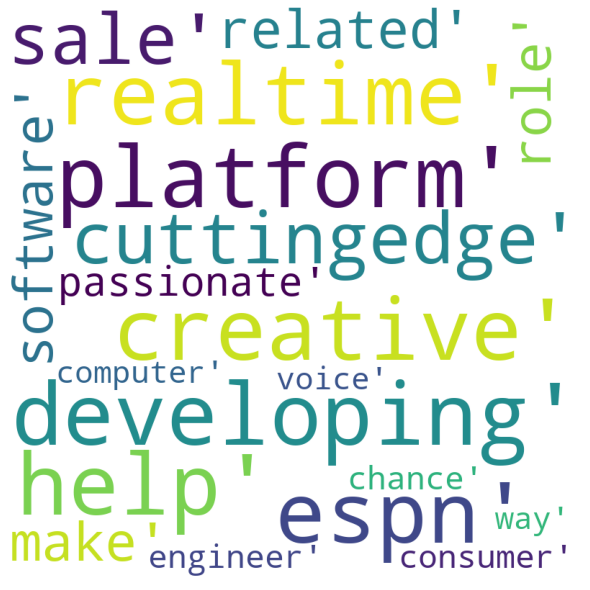

In [63]:
# I will now plot them 1 by 1. 
# Here is a word cloud representing most salient terms for topic 0
# software engineers
# salary: $70,000
# NB I will only define enough of them to illustrate the process

from matplotlib.figure import Figure


wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(stop), 
                min_font_size = 10).generate(str(topic_words[0]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [64]:
# from my topic details head above i can see the index 85 is in category 1
print(df['working title'].loc[85])
print(df['salary'].loc[85])

assistant
60000.0


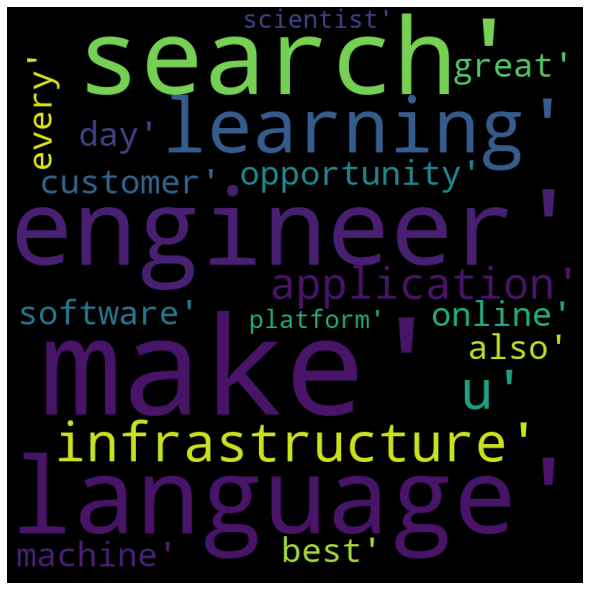

In [65]:
# assistant $60,000
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = set(stop), 
                min_font_size = 10).generate(str(topic_words[1]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()


In [66]:
print(df['working title'].loc[13])
print(df['salary'].loc[13])

software engineer
70000.0


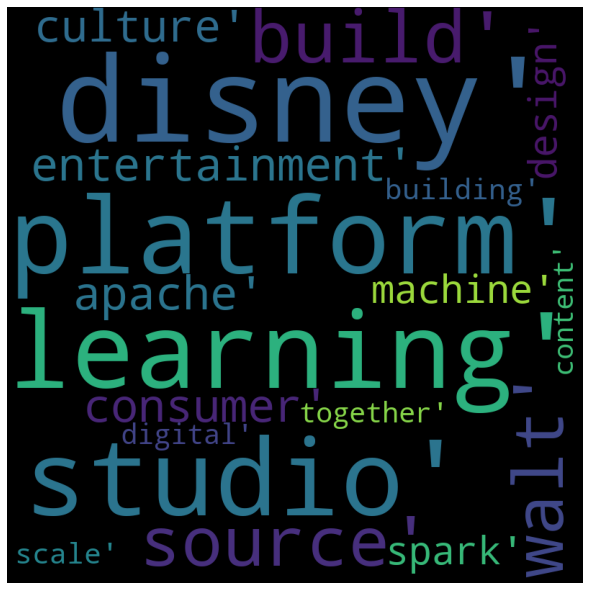

In [67]:
# software engineer, $70,000

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = set(stop), 
                min_font_size = 10).generate(str(topic_words[2]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()


In [68]:
print(df['working title'].loc[135])
print(df['salary'].loc[135])

research position
65000.0


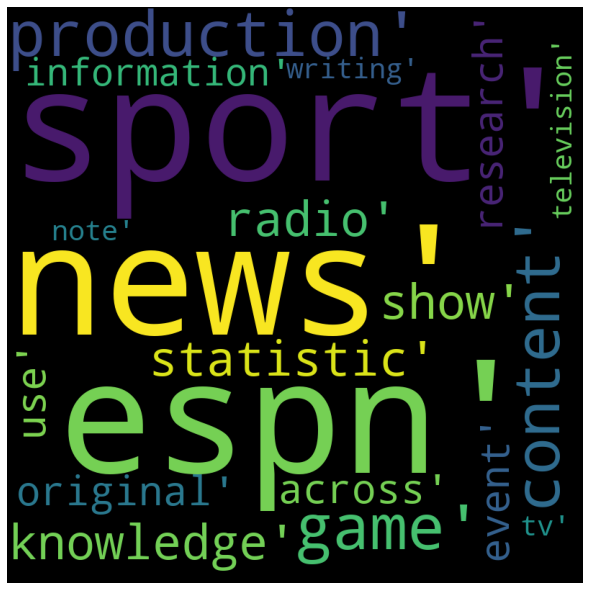

In [69]:
# research position $65000

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = set(stop), 
                min_font_size = 10).generate(str(topic_words[3]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [70]:
print(df['working title'].loc[394])
print(df['salary'].loc[394])

data scientist
127500.0


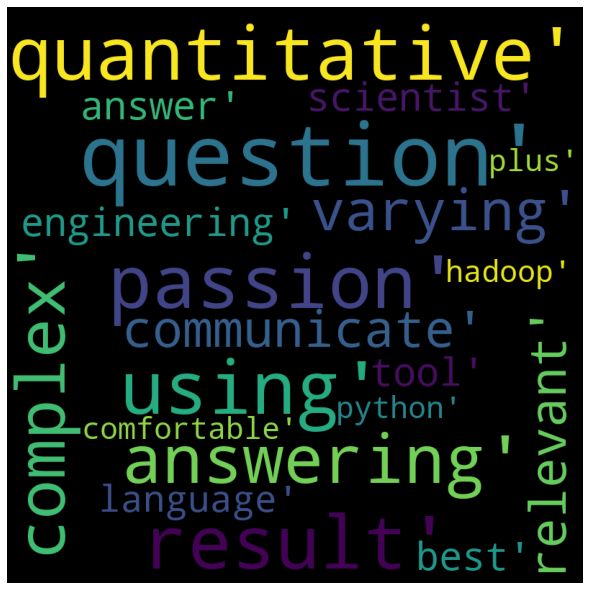

In [71]:
# data scientist $127,500
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = set(stop), 
                min_font_size = 10).generate(str(topic_words[4]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [72]:
print(df['working title'].loc[446])
print(df['salary'].loc[446])

senior data analyst
150000.0


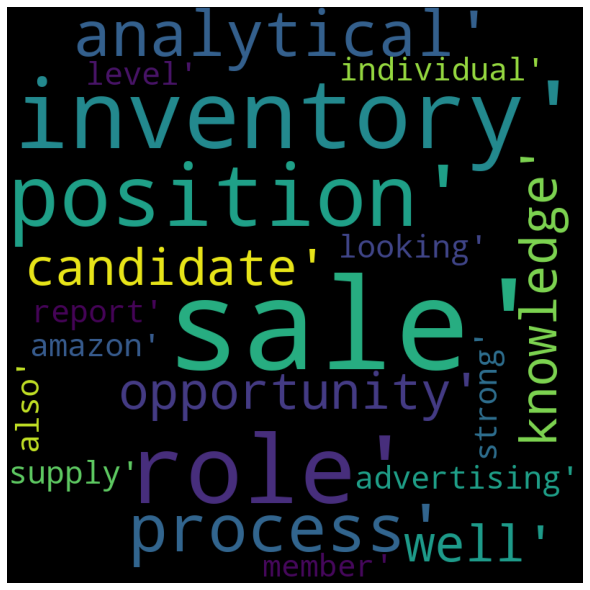

In [73]:
# senior data analyst, $150,000
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = set(stop), 
                min_font_size = 10).generate(str(topic_words[5]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [74]:
print(df['working title'].loc[124])
print(df['salary'].loc[124])

data analyst
75000.0


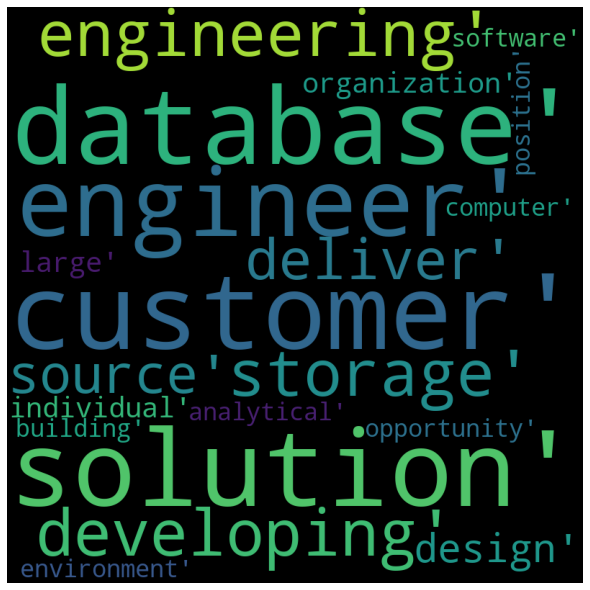

In [75]:
# data analyst, $75,000
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = set(stop), 
                min_font_size = 10).generate(str(topic_words[6]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [76]:
print(df['working title'].loc[211])
print(df['salary'].loc[211])

senior data engineer
132500.0


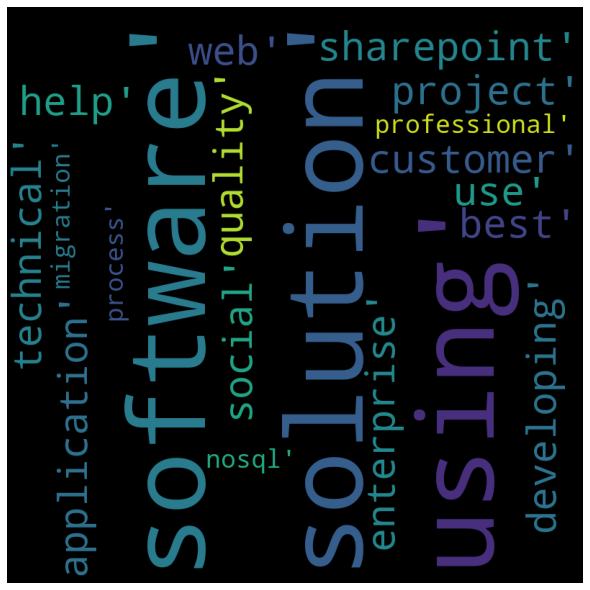

In [77]:
# senior data engineer 132,500
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = set(stop), 
                min_font_size = 10).generate(str(topic_words[7]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [78]:
print(df['working title'].loc[383])
print(df['salary'].loc[383])

data engineer
92500.0


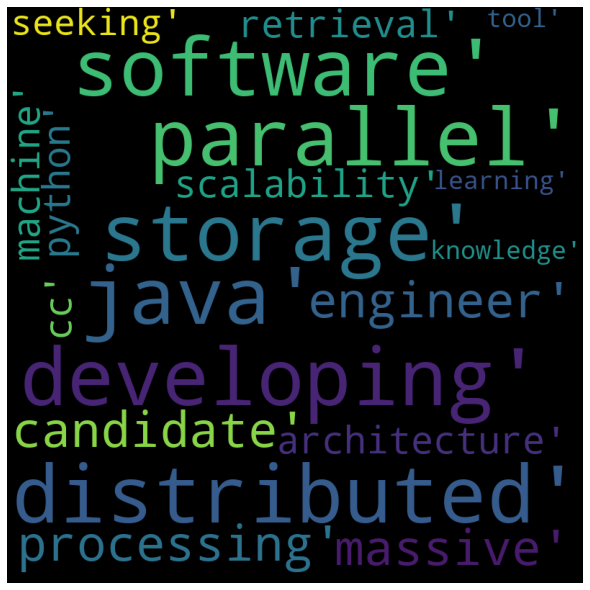

In [79]:
# Database engineer 92,500
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = set(stop), 
                min_font_size = 10).generate(str(topic_words[8]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [80]:
print(df['working title'].loc[283])
print(df['salary'].loc[283])

database administrator
60000.0


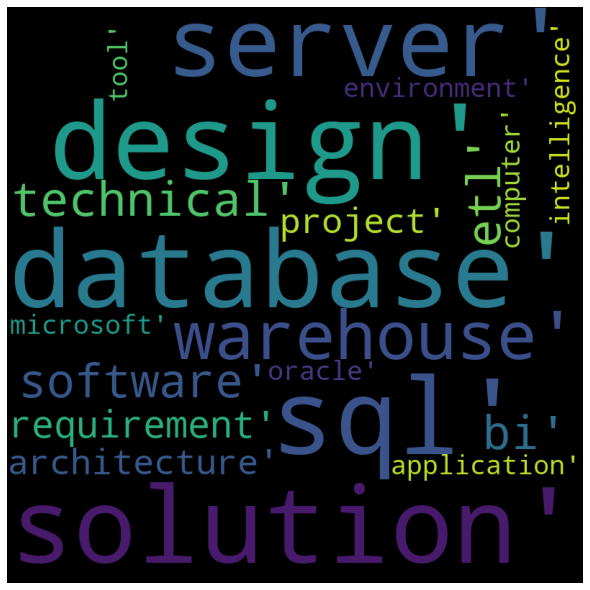

In [81]:
# database administrator 60,000
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = set(stop), 
                min_font_size = 10).generate(str(topic_words[9]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [83]:
print(df['working title'].loc[181])
print(df['salary'].loc[181])

vp data
190000.0


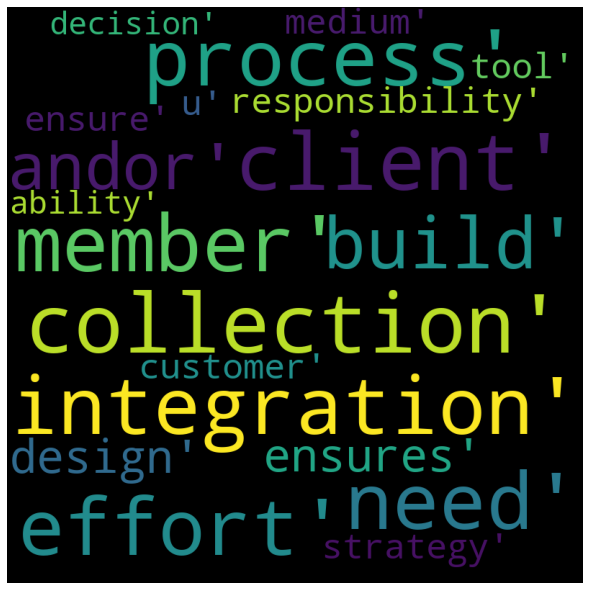

In [87]:
# vp data 190,000
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = set(stop), 
                min_font_size = 10).generate(str(topic_words[10]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

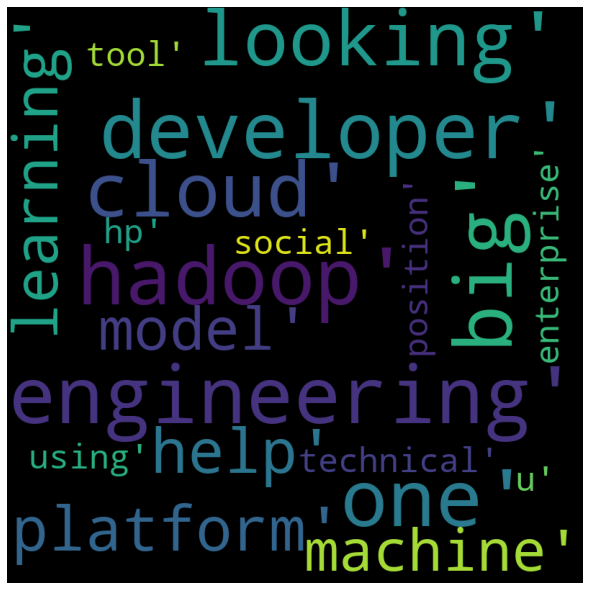

In [88]:
# 
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = set(stop), 
                min_font_size = 10).generate(str(topic_words[11]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

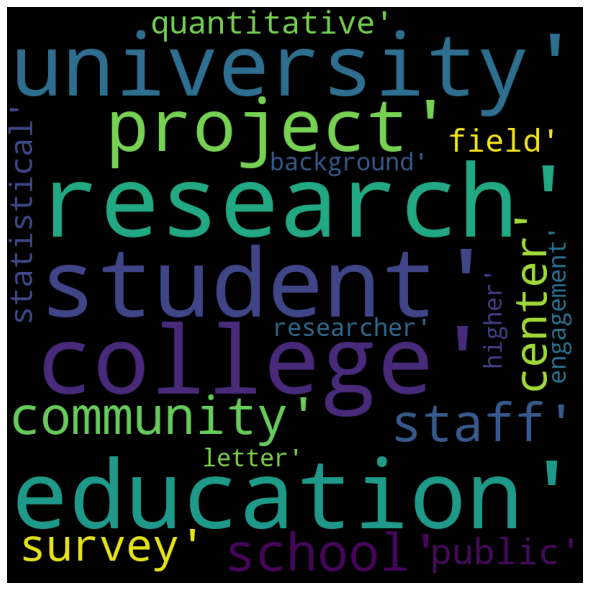

In [89]:

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = set(stop), 
                min_font_size = 10).generate(str(topic_words[12]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

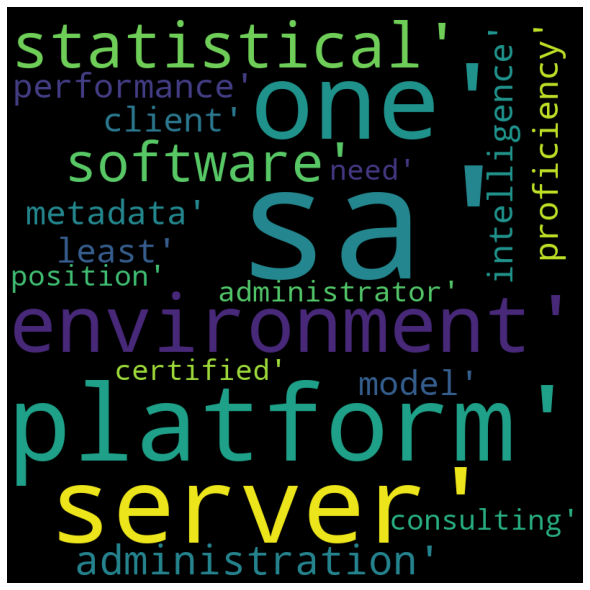

In [90]:
#
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = set(stop), 
                min_font_size = 10).generate(str(topic_words[13]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

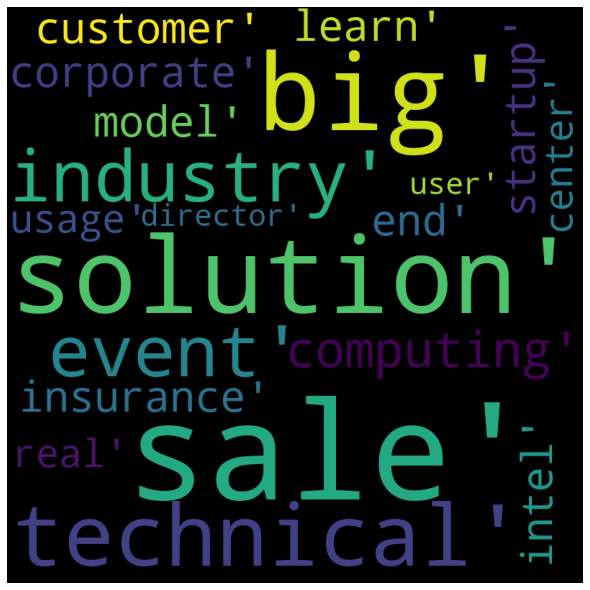

In [91]:

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = set(stop), 
                min_font_size = 10).generate(str(topic_words[14]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

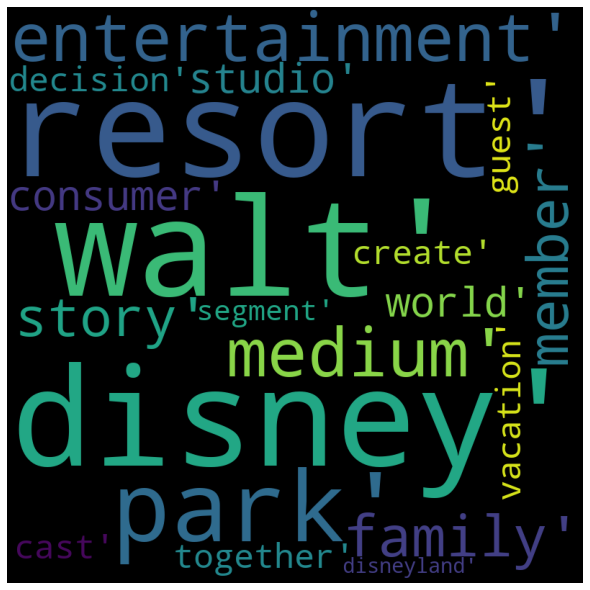

In [92]:
# 
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = set(stop), 
                min_font_size = 10).generate(str(topic_words[15]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

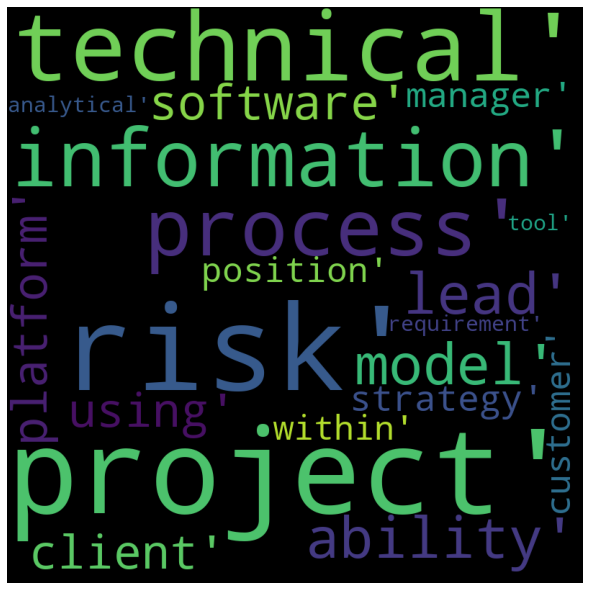

In [93]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = set(stop), 
                min_font_size = 10).generate(str(topic_words[17]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()


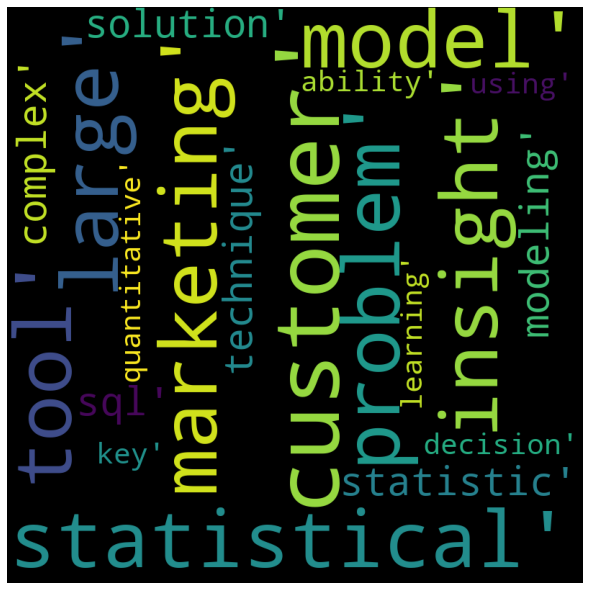

In [94]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = set(stop), 
                min_font_size = 10).generate(str(topic_words[18]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

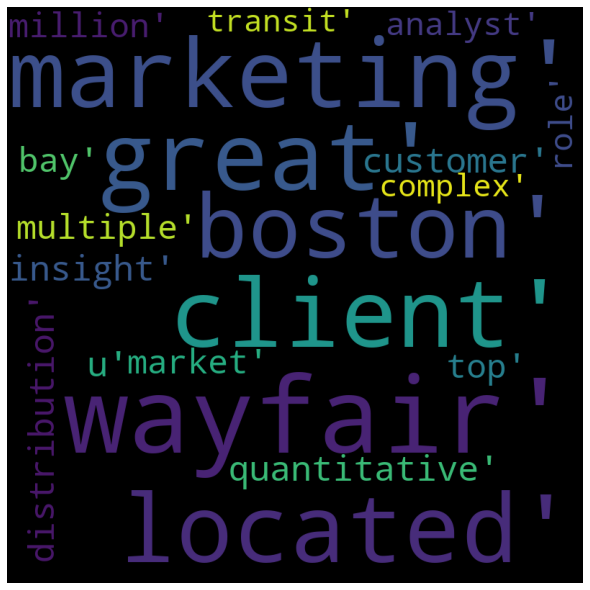

In [95]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = set(stop), 
                min_font_size = 10).generate(str(topic_words[19]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

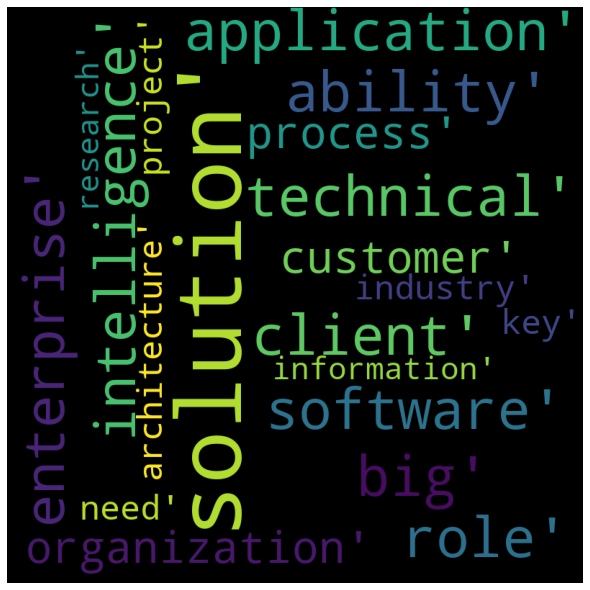

In [96]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = set(stop), 
                min_font_size = 10).generate(str(topic_words[20]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

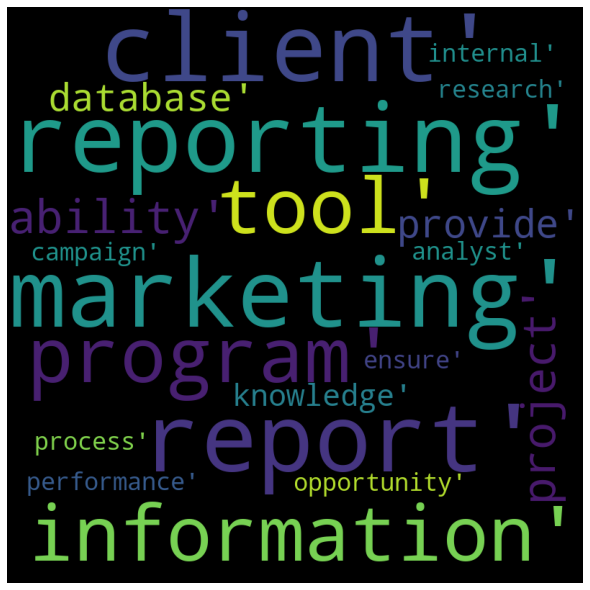

In [97]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = set(stop), 
                min_font_size = 10).generate(str(topic_words[21]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

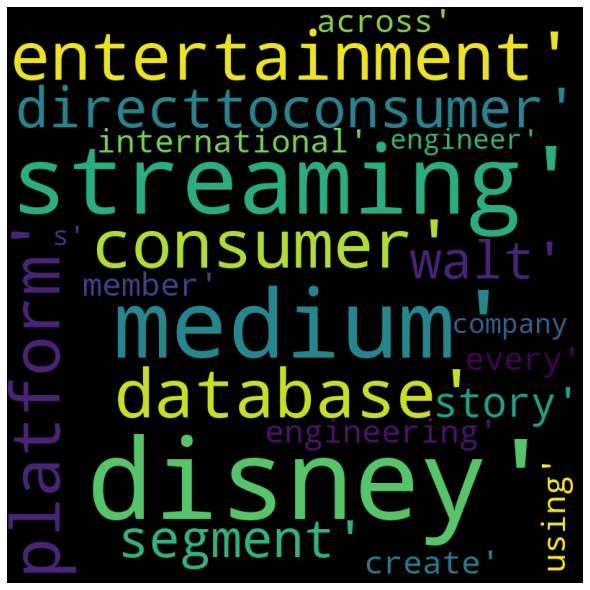

In [100]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = set(stop), 
                min_font_size = 10).generate(str(topic_words[22]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

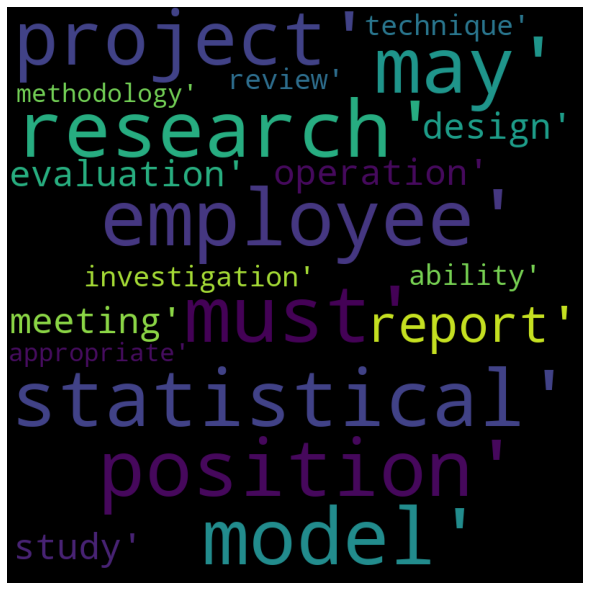

In [101]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = set(stop), 
                min_font_size = 10).generate(str(topic_words[24]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [102]:
# lets combine the list of topic_words lists into one flat list to look at which words
# most point to Data jobs overall 
# instead of a list of lists
all_salient_words = []
for sublist in topic_words:
    for item in sublist:
        all_salient_words.append(item)

all_salient_words

['–',
 'developing',
 'platform',
 'creative',
 'espn',
 'realtime',
 'help',
 'cuttingedge',
 'sale',
 'related',
 'software',
 'make',
 'role',
 'passionate',
 'engineer',
 'consumer',
 'chance',
 'computer',
 'voice',
 'way',
 'make',
 'engineer',
 'language',
 'search',
 'learning',
 'infrastructure',
 'u',
 'application',
 'opportunity',
 'every',
 'software',
 'customer',
 'machine',
 'best',
 'also',
 'online',
 'day',
 'great',
 'platform',
 'scientist',
 'disney',
 'platform',
 '–',
 'studio',
 'learning',
 'build',
 'source',
 'walt',
 'apache',
 'entertainment',
 'consumer',
 'culture',
 'machine',
 'design',
 'spark',
 'building',
 'scale',
 'together',
 'digital',
 'content',
 'sport',
 'espn',
 'news',
 'production',
 'game',
 'content',
 'knowledge',
 'radio',
 'statistic',
 'show',
 'original',
 'research',
 'across',
 'event',
 'use',
 'information',
 'writing',
 'tv',
 'note',
 'television',
 'question',
 'quantitative',
 'using',
 'result',
 'passion',
 'answering',


In [103]:
#looking at it as a set to filter out all repetition
set(all_salient_words) 

{'ability',
 'across',
 'administration',
 'administrator',
 'advertising',
 'also',
 'amazon',
 'analyst',
 'analytical',
 'andor',
 'answer',
 'answering',
 'apache',
 'application',
 'appropriate',
 'architecture',
 'background',
 'bay',
 'best',
 'bi',
 'big',
 'boston',
 'build',
 'building',
 'c',
 'campaign',
 'candidate',
 'cast',
 'cc',
 'center',
 'certified',
 'chance',
 'client',
 'cloud',
 'collection',
 'college',
 'comfortable',
 'communicate',
 'community',
 'company’s',
 'complex',
 'computer',
 'computing',
 'consulting',
 'consumer',
 'content',
 'corporate',
 'create',
 'creative',
 'culture',
 'customer',
 'cuttingedge',
 'database',
 'day',
 'decision',
 'deliver',
 'design',
 'developer',
 'developing',
 'digital',
 'director',
 'directtoconsumer',
 'disney',
 'disneyland',
 'distributed',
 'distribution',
 'education',
 'effort',
 'employee',
 'end',
 'engagement',
 'engineer',
 'engineering',
 'ensure',
 'ensures',
 'enterprise',
 'entertainment',
 'environment

In [104]:
# In order to understand these salient words better
# lets look at their rank significance throughout the whole data set
# let's run them through TFIDF
len(set(all_salient_words))

254

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
vectorizer = TfidfVectorizer(lowercase=False)
matrix = vectorizer.fit_transform(all_salient_words).todense()
# transform the matrix to a pandas df
matrix = pd.DataFrame(matrix, columns=vectorizer.get_feature_names())
# sum over each list (axis=0)
top_words = matrix.sum(axis=0).sort_values(ascending=False)

In [107]:
# these are my top 20 words
# in ranked order

top_words.head(20)

customer       10.0
software       10.0
tool            8.0
project         8.0
solution        7.0
client          7.0
platform        7.0
ability         6.0
member          6.0
model           6.0
using           6.0
position        6.0
process         6.0
technical       6.0
consumer        5.0
opportunity     5.0
design          5.0
engineer        5.0
research        5.0
learning        5.0
dtype: float64

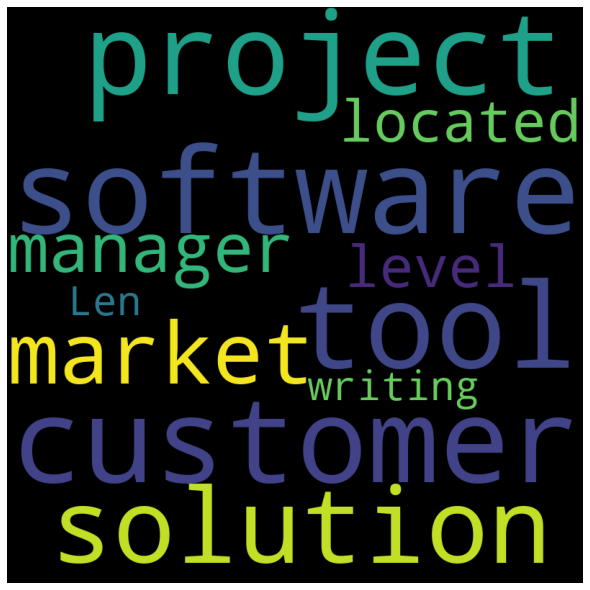

In [141]:
# just looking at what this does on the post TFIDF important words
# I will explain to the recruiter that these are the words that point most
# to data jobs in general
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black',
                max_words=204, 
                stopwords = set(stop), 
                min_font_size = 4).generate(str(top_words)[0:190])

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

Observations against my hypothesis: The clustering trends thagt I expected to see are quite similar to what I have seen and yet, I'm glad that the words chosen through the LDA process are often able to consitently predicted a job category with high probabilty overall.

# Part 2 - Factors that predict Data Scientist Jobs vs other Data Jobs 

In [0]:
# this is abinary classification problem
# data science job title - can I predict from desc
# target is data science job vs non data science job
# apply count vectorizor
# logistic regression, multinomialNB
# look at baseline
# calculate cross val and accuracy score


In [110]:
# create a column for binary labels, data science jobs will be one, other will be 0
df['binary_job_title'] = df['working title']

df.sample(10)

end_url  ...               binary_job_title
492       Vistaprint/Senior-Analyst-Marketing-Job~1037  ...            senior data analyst
401         Beatport/Data-Warehouse-Developer-Job~1942  ...                        vp data
201   3Sharp/Business-Intelligence-Consultant-Job~4734  ...  business intelligence analyst
203  Highlight-Technologies-LLC/-NET-Software-Devel...  ...                        vp data
354                     Hibu/Search-Architect-Job~2425  ...                 data scientist
372  Amazon/Business-Intelligence-Analyst-Digital-M...  ...  business intelligence analyst
187     Well-Lighthouse/Deputy-Data-Scientist-Job~5248  ...                 data scientist
393                   Facebook/Data-Scientist-Job~2014  ...                 data scientist
45   Disney-Parks-Resorts/Digital-and-Travel-Ops-An...  ...                        vp data
172          TradeKing/Web-Conversion-Analyst-Job~5805  ...                   data analyst

[10 rows x 11 columns]

In [111]:
# setting data science jobs to 1
df.binary_job_title[df.binary_job_title == 'data scientist'] = 1
df.binary_job_title[df.binary_job_title == 'senior data scientist'] = 1
df.binary_job_title[df.binary_job_title == 'vp data'] = 1
df.sample(5)

end_url  ...                      binary_job_title
366  Amazon/Manager-Business-Intelligence-Global-Pa...  ...  senior business intelligence analyst
386  Facebook/Data-Engineer-Visualization-Reporting...  ...                                     1
480  Google/Corporate-Engineering-Data-Scientist-Jo...  ...                                     1
266    NutraClick/DBA-Architect-Data-Engineer-Job~3515  ...                         data engineer
365  Amazon/Business-Intelligence-Manager-Amazon-In...  ...  senior business intelligence analyst

[5 rows x 11 columns]

In [0]:
# defaulting all other job titles to 0
df['binary_job_title'] = df['binary_job_title'].map(lambda x: 1 if x==1 else 0)

In [0]:
# setting my y and X values
X = df.desc
y = df.binary_job_title.values

In [0]:
 from sklearn.model_selection import train_test_split

# splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


In [0]:
# count vectorize X train and X test
vect = CountVectorizer(ngram_range=(1,2), stop_words=stop, min_df=10)
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)

X_test_dtm = vect.transform(X_test)

In [116]:
# confirming shapes match
X_train_dtm.shape

(373, 2444)

In [117]:
X_test_dtm.shape

(125, 2444)

In [118]:
# last 50 features
print(vect.get_feature_names()[-50:])

['without regard', 'word', 'work', 'work across', 'work closely', 'work cross', 'work effectively', 'work environment', 'work experience', 'work independently', 'work team', 'work together', 'work well', 'worked', 'workflow', 'workflows', 'working', 'working big', 'working closely', 'working data', 'working knowledge', 'working large', 'works', 'world', 'world class', 'world largest', 'world leading', 'world popular', 'world resort', 'worldwide', 'would', 'write', 'writing', 'written', 'written communication', 'written oral', 'written verbal', 'www', 'xml', 'year', 'year experience', 'years', 'years ago', 'years data', 'years experience', 'years hands', 'years professional', 'years relevant', 'york', 'youtube']


In [0]:
#create df according to feature names, values according to job title binaries
# convert to dense to avoid NaN values auto replacing 0s
X_train_dtm = pd.DataFrame(X_train_dtm.todense(), columns=vect.get_feature_names())


In [120]:
# View it
X_train_dtm

000  10  10 years  100  ...  years professional  years relevant  york  youtube
0      0   0         0    0  ...                   0               0     0        3
1      0   0         0    0  ...                   0               0     0        0
2      0   0         0    0  ...                   0               0     0        0
3      0   0         0    0  ...                   0               0     0        0
4      0   0         0    0  ...                   0               0     0        0
..   ...  ..       ...  ...  ...                 ...             ...   ...      ...
368    0   0         0    0  ...                   0               0     0        0
369    0   0         0    0  ...                   0               2     0        0
370    0   0         0    0  ...                   0               0     0        0
371    0   0         0    0  ...                   0               0     0        0
372    0   0         0    0  ...                   0               0     0        0

[373 rows x 2444 columns]

In [121]:
# view y
y_train

array([0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,

In [122]:
# get a cross val score on my train set
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
lr = LogisticRegression()
scores = cross_val_score(lr, X_train_dtm, y_train, cv=10)
print(scores)

[0.78947368 0.81578947 0.71052632 0.62162162 0.59459459 0.7027027
 0.67567568 0.81081081 0.67567568 0.67567568]


In [123]:
# with default settings for count vectorizer
# fit and predict my Logistice Regression model

from sklearn import metrics

# using Logistic Regression to predict data scientist jobs, both senior and non
lr = LogisticRegression()
lr.fit(X_train_dtm, y_train)
y_pred_class = lr.predict(X_test_dtm)


# calculate accuracy
print(metrics.accuracy_score(y_test, y_pred_class))

0.768


In [124]:
# looking at the spread in coefs
lr.coef_

array([[ 0.13738674, -0.01234324, -0.01044578, ...,  0.05048633,
         0.01601988, -0.01770449]])

In [0]:
from sklearn.naive_bayes import MultinomialNB
# define a function that accepts a vectorizer
# with default settings for count vectorizer
# runs off a MultinomialNB model
# and calculate the accuracy
def tokenize_test(vect):
    X_train_dtm = vect.fit_transform(X_train)
    print('Features: ', X_train_dtm.shape[1])
    X_test_dtm = vect.transform(X_test)
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)
    print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))

In [126]:
# checking the basline
Baseline = 1- y_train.mean()
Baseline

0.6300268096514745

In [127]:
# my model outperforms the baseline
vect = CountVectorizer()
tokenize_test(vect)

Features:  11964
Accuracy:  0.808


In [139]:
# my model predicts data scientist well compared with non data scientist
from sklearn.metrics import classification_report

target_names = ['Data Scientist', 'Non-Data Scientist']
print(classification_report(y_test, y_pred_class, target_names=target_names))

                    precision    recall  f1-score   support

    Data Scientist       0.82      0.86      0.84        88
Non-Data Scientist       0.62      0.54      0.58        37

          accuracy                           0.77       125
         macro avg       0.72      0.70      0.71       125
      weighted avg       0.76      0.77      0.76       125



In [0]:
# saving my dfs to csv

In [0]:
df.to_csv('job_scrape.csv')
!cp job_scrape.csv "drive/My Drive//Data Science Intensive GA/"

In [0]:
topic_details.to_csv('LDA_proj4.csv')
!cp job_scrape.csv "drive/My Drive//Data Science Intensive GA/"

In [0]:
topic_details_1.to_csv('LDA_flag_proj4.csv')
!cp job_scrape.csv "drive/My Drive//Data Science Intensive GA/"

As a company trying to stay competitive in the Data Jobs market, I know how important it is for you to understand the trends in the industry. In order to provide you with this understanding, I based my research on Data that I compiled using a process called 'data scraping' from job listings on a the Datajobs.com website. They focus only on the various jobs available in the US data industry, so they are an excellent resource. 



Just to give you a sense of what these types of jobs pay, on average, Data Scientist jobs, both senior, $170k, and associate, $127.5k pay considerably better than Data Analyst jobs. However, it's important to note, that as Analysts acquire specific areas of expertise, such as business intelligence analysis, their potential outcomes improve. Additionally, when they become a senior data analyst or senior business intelligence analysts, they can see a jump in salary of up to $75000.  

That being said the jobs that do bring in the very top jobs are Vice presidents of Data. They earn an average of $190k per year. 

Senior data engineers, senior software engineers and senior product managers all earn salaries in the higher ranges, $125k and up.

Utilising another technique called Natural Language Processing(NLP) I analysed the language used across 500 data job descriptions and then through a clustering technique called Latent Dirichlet Allocation, along with the step of mapping its results back to my original data, I was able to pull out a collection of keywords that you may want to include in your recruitment language.

On the most basic level, be sure to discuss the **customer** that they will foucs on and the specifics of the **position** that they will be filling. Be up front about the **length** of their **position** and ensure that they have a **passion** for the work. Also make sure to inform them regarding the **tools**, **platform**s and **software** you will require them to have considerable **abilty** to use.

Zooming in on what best describes a data scientist position.Make sure to start with those general rules and then get more specific. Use words like **python** and **hadoop** in terms of **tool**s, platforms and software, confirm there **engineering**, **statistical**, **quantitative**  and **communicative** skills are up to par. Most off all, remind them that as a data **scientist** they will have to ask the **relevant** **question**s to get the **best** **results**.

NB bolded words above are top words fist accross all job listing and then specifically for Data Scientist jobs